**Ch 5 합성곱신경망1**


**5-1 합성곱 신경망**

*   이미지를 펼쳐서 분석하면 공간적 구조가 무시되어 이를 방지하고자 사용

합성 신경망의 구조
*   입력층
*   합성곱층 - 입력 데이터에서 특성을 추출
*   풀링층 - 특성맵의 차원을 다운샘플링하여 연산량 감소
    *   최대 풀링
    *   평균 풀링
*   완전연결층 - 차원이 축소된 특성맵이 1차원 벡터로 펼쳐진다
*   출력층


**5-2 합성곱 신경망 맛보기**

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 데이터셋 내려받기
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data",download=True,train=False,transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 17297926.41it/s]


Extracting ../chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299437.34it/s]


Extracting ../chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5527122.14it/s]


Extracting ../chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9053365.62it/s]

Extracting ../chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



In [4]:
# 데이터를 데이터로더로 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) # 100개 단위로 묶어서 불러온다
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

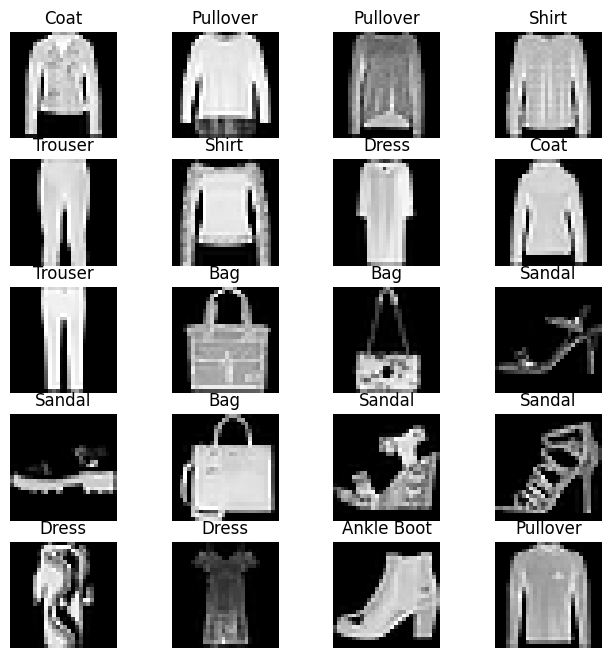

In [5]:
# 분류에 사용될 클래스 정의
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [6]:
# 심층 신경망 모델 DNN 생성 (ConvNet이 적용되지 않은 네트워크)
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # Linear: 단순 선형 회귀 모델
        self.drop = nn.Dropout(0.25)  # nn.Dropout(p): p만큼의 비율로 텐서 값이 0이 됨
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
# 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not(count % 500):
            print(f"Ieration: {count}, Loss: {loss.data:.2f}, Accuracy: {accuracy:.2f}%")

Ieration: 500, Loss: 0.59, Accuracy: 82.81%
Ieration: 1000, Loss: 0.42, Accuracy: 84.00%
Ieration: 1500, Loss: 0.36, Accuracy: 84.79%
Ieration: 2000, Loss: 0.40, Accuracy: 84.99%
Ieration: 2500, Loss: 0.26, Accuracy: 86.42%
Ieration: 3000, Loss: 0.31, Accuracy: 86.75%


In [9]:
# 합성곱 네트워크 생성 CNN
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # 합성곱층에서 완전 연결층으로 변형되기 때문에 데이터의 형태를 1차원으로 바꿔준다
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [10]:
# 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not(count % 500):
            print(f"Ieration: {count}, Loss: {loss.data:.2f}, Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Ieration: 500, Loss: 0.49, Accuracy: 87.53%
Ieration: 1000, Loss: 0.36, Accuracy: 87.74%
Ieration: 1500, Loss: 0.32, Accuracy: 86.54%
Ieration: 2000, Loss: 0.25, Accuracy: 89.27%
Ieration: 2500, Loss: 0.13, Accuracy: 89.76%
Ieration: 3000, Loss: 0.19, Accuracy: 90.73%


이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 사용한다

**5-3 전이학습**

전이학습
*   합성곱 신경망 기반의 딥러닝 모델을 훈련시키려면 많은 양의 데이터 필요
*   아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 보정해서 사용
*   특성 추출
    *   사전 훈련된 모델을 가져온 후 마지막에 완전연결층만 새로 만든다
*   미세 조정 기법
    *   특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식



In [12]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# 이미지 데이터 전처리 방법 정의
data_path = "/content/drive/MyDrive/catanddog/train"

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),  # 합성곱층을 통과하기 위해 이미지 크기 조정
        transforms.RandomResizedCrop(224),    # 데이터 확장
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True
)

print(len(train_dataset))

402


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


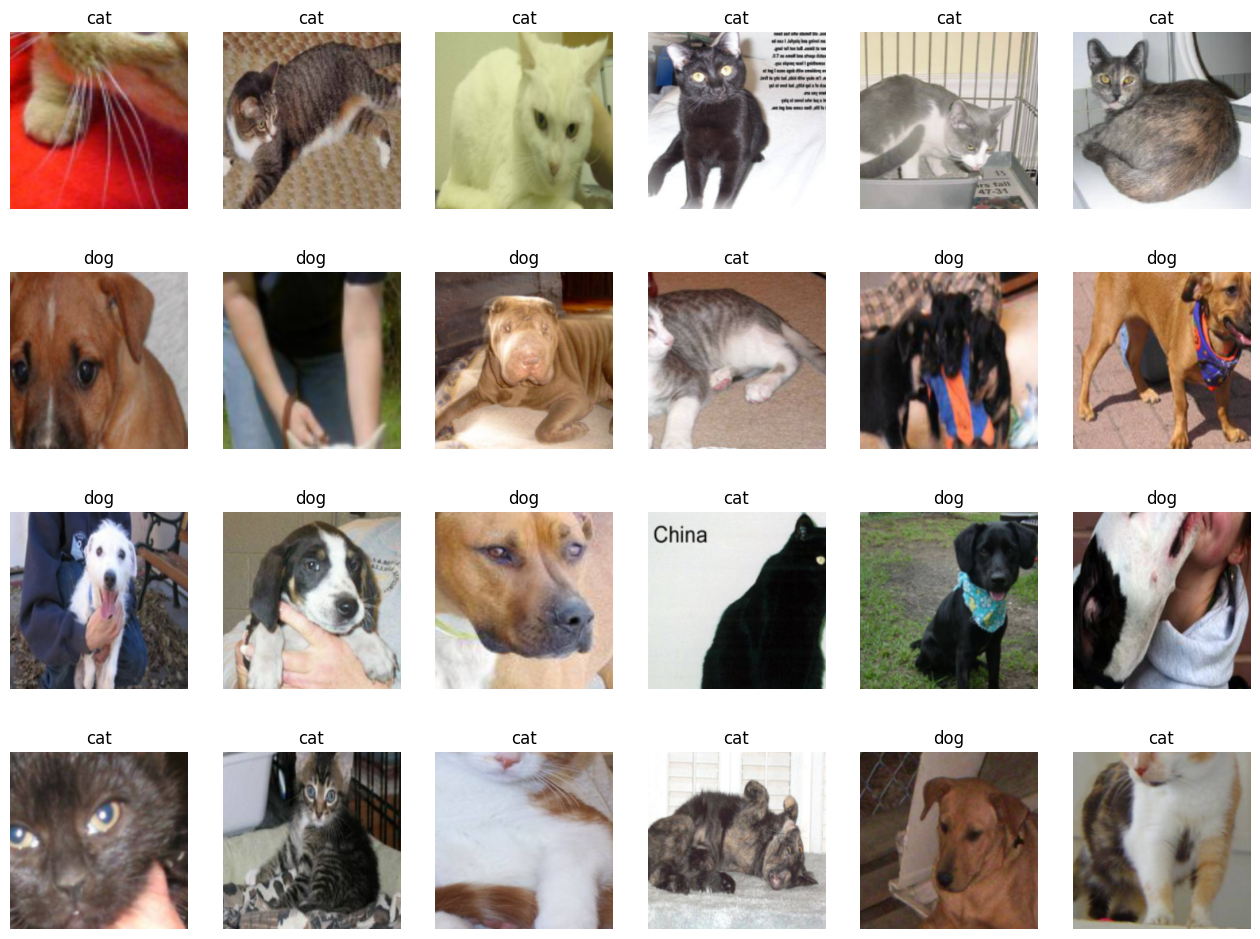

In [15]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader))

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))

for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [16]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [17]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [18]:
# 완전연결층 추가
resnet18.fc = nn.Linear(512,2)

In [19]:
# 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0256, -0.0351,  0.0398,  ...,  0.0317,  0.0022, -0.0365],
        [-0.0308, -0.0304,  0.0350,  ...,  0.0308, -0.0255,  0.0247]])
fc.bias tensor([-0.0073, -0.0045])


In [20]:
# 모델 객체 생성 및 손실함수 정의
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad =True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-"*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += (loss.item() * inputs.size(0))
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss/len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print(f"Loss: {epoch_loss:.4f}     Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/catanddog/', "{0:0=2d}.pth".format(epoch))) # 모델 재사용을 위해 저장

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60 :.0f}m {time_elapsed%60 :.0f}s")
    print(f"Best Acc: {best_acc:.4f}")

    return acc_history, loss_history

In [22]:
# 파라미터 학습 결과를 옵티마이저에게 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [23]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device, num_epochs=13, is_train=True)

Epoch 0/12
----------
Loss: 0.5190     Acc: 0.7488

Epoch 1/12
----------
Loss: 0.3371     Acc: 0.8756

Epoch 2/12
----------
Loss: 0.2631     Acc: 0.9080

Epoch 3/12
----------
Loss: 0.2466     Acc: 0.9030

Epoch 4/12
----------
Loss: 0.2200     Acc: 0.9179

Epoch 5/12
----------
Loss: 0.2027     Acc: 0.9179

Epoch 6/12
----------
Loss: 0.2008     Acc: 0.9154

Epoch 7/12
----------
Loss: 0.2610     Acc: 0.8756

Epoch 8/12
----------
Loss: 0.1770     Acc: 0.9328

Epoch 9/12
----------
Loss: 0.1847     Acc: 0.9378

Epoch 10/12
----------
Loss: 0.1868     Acc: 0.9179

Epoch 11/12
----------
Loss: 0.1782     Acc: 0.9303

Epoch 12/12
----------
Loss: 0.1763     Acc: 0.9229

Training complete in 10m 36s
Best Acc: 0.9378


In [24]:
# 테스트 데이터 호출 및 전처리
test_path = "/content/drive/MyDrive/catanddog/test"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

102


In [25]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob("/content/drive/MyDrive/catanddog/" + "*.pth")
    saved_models.sort()
    print("saved_model", saved_models)

    for model_path in saved_models:
        print("Loading model", model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print(f"Validation complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")

    return acc_history

In [26]:
# 테스트 데이터를 평가함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/catanddog/00.pth', '/content/drive/MyDrive/catanddog/01.pth', '/content/drive/MyDrive/catanddog/02.pth', '/content/drive/MyDrive/catanddog/03.pth', '/content/drive/MyDrive/catanddog/04.pth', '/content/drive/MyDrive/catanddog/05.pth', '/content/drive/MyDrive/catanddog/06.pth', '/content/drive/MyDrive/catanddog/07.pth', '/content/drive/MyDrive/catanddog/08.pth', '/content/drive/MyDrive/catanddog/09.pth', '/content/drive/MyDrive/catanddog/10.pth', '/content/drive/MyDrive/catanddog/11.pth', '/content/drive/MyDrive/catanddog/12.pth']
Loading model /content/drive/MyDrive/catanddog/00.pth
Acc: 0.7549

Loading model /content/drive/MyDrive/catanddog/01.pth
Acc: 0.9412

Loading model /content/drive/MyDrive/catanddog/02.pth
Acc: 0.9216

Loading model /content/drive/MyDrive/catanddog/03.pth
Acc: 0.9510

Loading model /content/drive/MyDrive/catanddog/04.pth
Acc: 0.9706

Loading model /content/drive/MyDrive/catanddog/05.pth
Acc: 0.9706

Loading model /content/dri

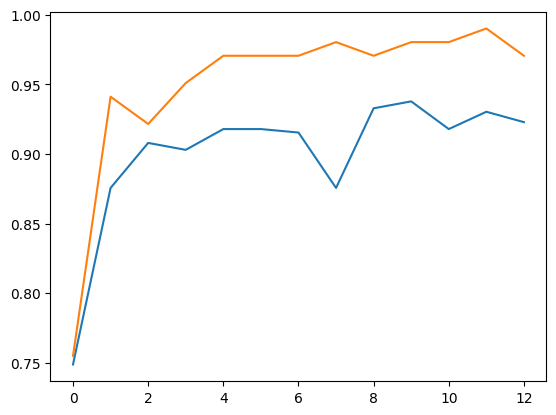

In [27]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

In [28]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [32]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

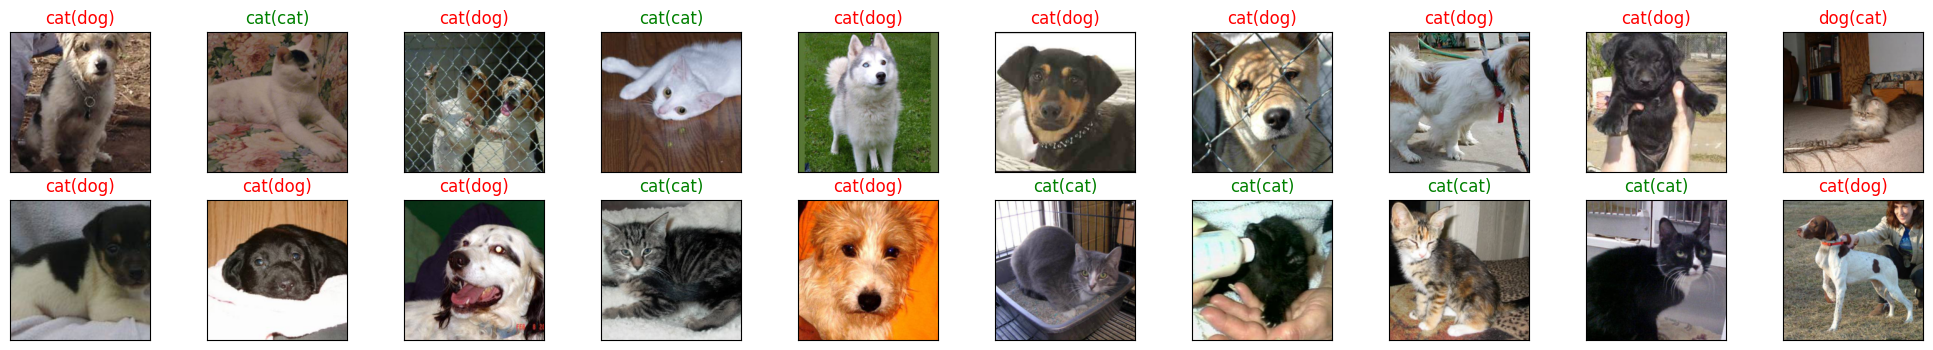

<Figure size 640x480 with 0 Axes>

In [33]:
# 예측 결과 출력
classes = {0:'cat', 1:'dog'}

images,labels=next(iter(test_loader))
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

**5-4 설명 가능한 CNN**

CNN 필터와 특성 맵 시각화를 통해 신뢰성을 확보

In [34]:
# 라이브러리 호출
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# 네트워크 생성
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [36]:
# 모델 객체화
model=XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [37]:
# 특성 맵 확인을 위한 클래스 정의
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


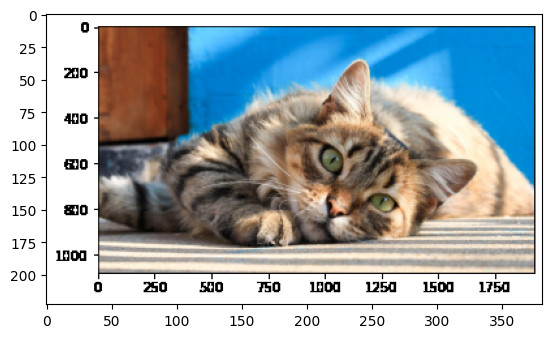

In [38]:
# 이미지 호출
img=cv2.imread("/content/drive/MyDrive/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [39]:
# Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

<ipython-input-35-fb6bf3dfaf1a>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


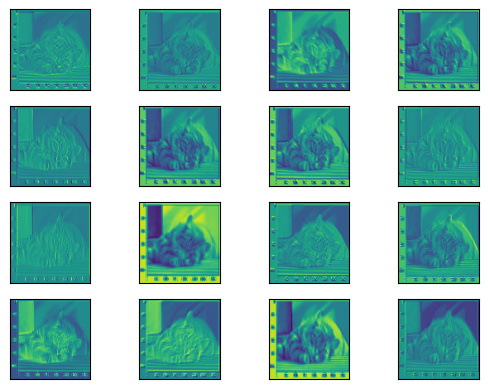

<Figure size 1200x800 with 0 Axes>

In [40]:
# 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

<ipython-input-35-fb6bf3dfaf1a>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


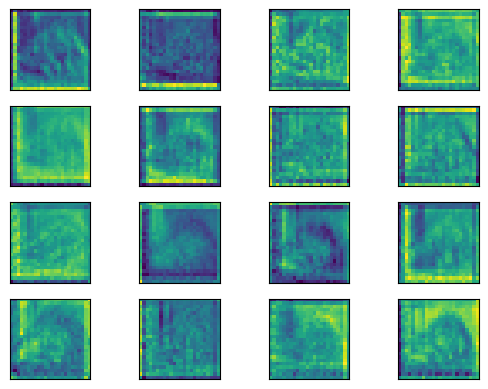

<Figure size 1200x800 with 0 Axes>

In [41]:
# 20번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])
plt.show()

<ipython-input-35-fb6bf3dfaf1a>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


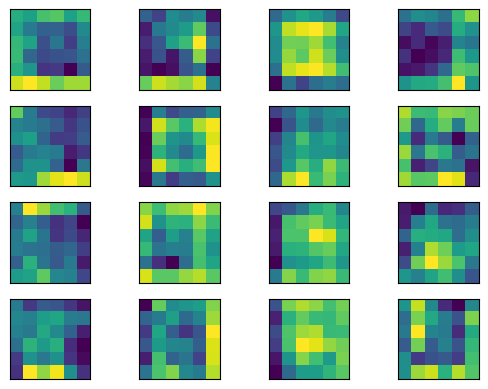

<Figure size 1200x800 with 0 Axes>

In [42]:
# 40번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])
plt.show()